### Comparing Linear Bayesian Regressors

This notebook is an implementation of the examples in scikit learn user guide: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html#sphx-glr-auto-examples-linear-model-plot-ard-py

This example compares two different bayesian regressors: [Automatic Relevance Determination, ARD] vs [Bayesian Ridge Regression] 

We begin with an OLS model as a baseline for comparing the models' coefficients w.r.t. the true coefficients. Then, we show that the estimation of such moels is done by iteratively maximizing the marginal log-likelihood of the observations. Finally, we plot predictions and uncertainities for ARD and Bayesian Ridge using polynomial feature expansion to fit a non-linear relationship between X and y. 

### Models robustness to recover the ground truth weights
<b> Generate synthetic dataset</b>

Generating a dataset where X and y are linearly linked: 10 of the features of X will be used to generate y. Other features are NOT useful at predicting y. In addition, generate a dataset where n_samples == n_features. Such a setting is challenging for an OLS model and leads potentially to arbitrary large weights. Having a prior on the weights and a penalty alleviates the problem. Finally, gaussian noise is added. 

In [2]:
from sklearn.datasets import make_regression
X, y, true_weights = make_regression(
                                        n_samples = 100,
                                        n_features = 100, 
                                        n_informative = 10, 
                                        noise = 8, 
                                        coef = True, 
                                        random_state = 42
                                    )

<b>Fit the regressors</b> \
Fitting both bayesian models and the OLS for comparison. 

In [4]:
import pandas as pd
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge

olr = LinearRegression().fit(X, y)
brr = BayesianRidge(compute_score = True, n_iter = 30).fit(X, y)
ard = ARDRegression(compute_score = True, n_iter = 30).fit(X, y)

df = pd.DataFrame(
                    {
                        "Weights of True Generative Process": true_weights,
                        "ARDRegression": ard.coef_,
                        "BayesianRidge": brr.coef_,
                        "LinearRegression": olr.coef_
                        
                    }
                 )

In [11]:
print(df['Weights of True Generative Process'].nunique())
print(df['ARDRegression'].nunique())
print(df['BayesianRidge'].nunique())
print(df['LinearRegression'].nunique())

11
100
100
100


In [15]:
mask = df['Weights of True Generative Process']!=0
df[mask]['Weights of True Generative Process'].size

10

In [38]:
mask = df['ARDRegression']!=0.0
df[mask]['ARDRegression'].size

100

In [42]:
mask = df['ARDRegression']<0.00000005
df[mask]['ARDRegression'].size

54

In [21]:
mask = df['BayesianRidge']!=0.0
df[mask]['BayesianRidge'].size

100

In [20]:
mask = df['LinearRegression']!=0.0
df[mask]['LinearRegression'].size

100

<b>Plot the true and estimated coefficients</b>

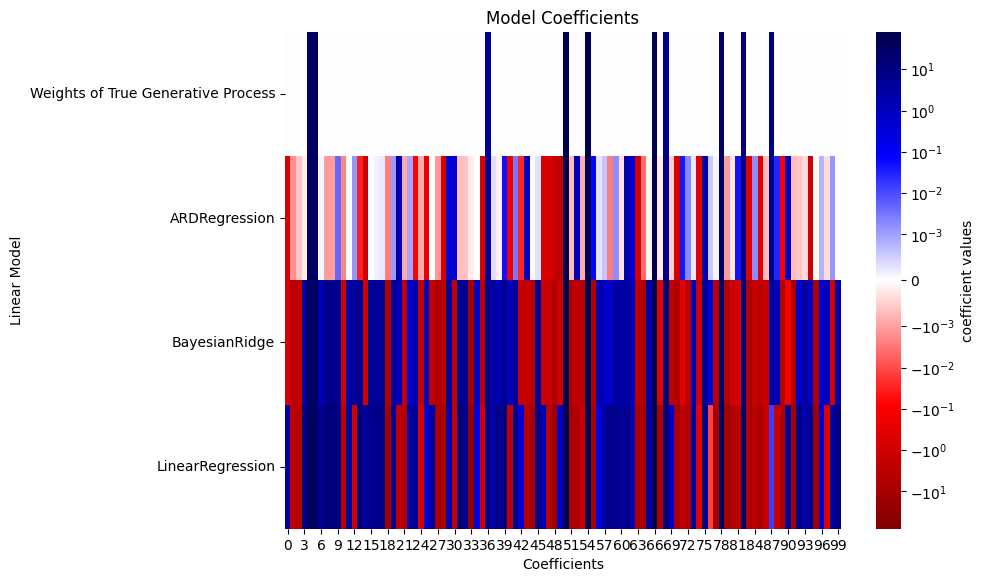

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize = (10, 6))
ax = sns.heatmap(df.T, norm = SymLogNorm(linthresh = 10e-4, vmin = -80, vmax = 80),
                                    cbar_kws = {'label': 'coefficient values'},
                                        cmap = 'seismic_r',
                )

plt.ylabel("Linear Model")
plt.xlabel("Coefficients")
plt.tight_layout(rect = (0, 0, 1, 0.95))
_ = plt.title("Model Coefficients")

Due to the added noise, none of the models recover the true weights. Indeed, all the models always have more than 10 non-zero coefficients. Compared to the OLS estimator, the coefficients using a Bayesian Ridge are slightly shifted towards zero, which stabilizes them. ARD provides a sparser solution: some of the non-informative coefficients are set very very near to zero. 

<b>Plot the marginal log-likelihood</b>

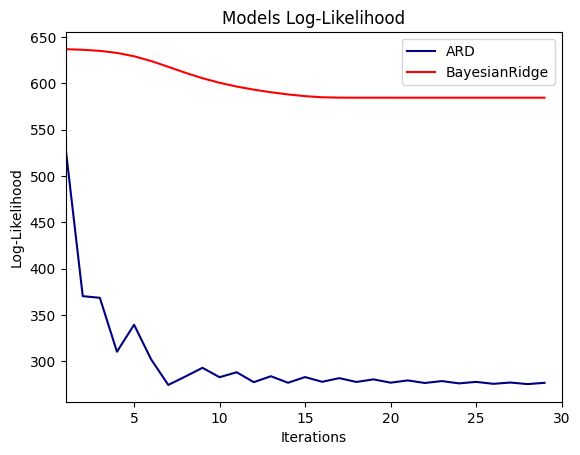

In [43]:
import numpy as np

ard_scores = -np.array(ard.scores_)
brr_scores = -np.array(brr.scores_)

plt.plot(ard_scores, color = "navy", label = "ARD")
plt.plot(brr_scores, color = 'red', label = 'BayesianRidge')
plt.ylabel('Log-Likelihood')
plt.xlabel('Iterations')
plt.xlim(1, 30)
plt.legend()
_ = plt.title("Models Log-Likelihood")

Both models minimize the log-likelihood up to an arbitrary cutoff defined by the n_iter parameter. 

### Bayesian Regressions with Polynomial Feature Expansion
<b>Generate synthetic dataset</b>

We create a target that is a non-linear function of the input feature. Noise following a standard uniform distribution is added. 

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

rng = np.random.RandomState(0)
n_samples = 110

# sort the data to make ploting easier 

X = np.sort(-10*rng.rand(n_samples) + 10)
noise = rng.normal(0, 1, n_samples)*1.35

y = np.sqrt(X)*np.sin(X)+noise
full_data = pd.DataFrame({"input_feature": X, "target": y})
X = X.reshape((-1, 1))

# extrapolation
X_plot = np.linspace(10, 10.4, 10)
y_plot = np.sqrt(X_plot)*np.sin(X_plot)
X_plot = np.concatenate((X, X_plot.reshape(-1, 1)))
y_plot = np.concatenate((y-noise, y_plot))

<b>Fit the regressors</b> 

Trying a degree 10 polynomial to potentially overfit, though the bayesian linear models regularize the size of the polynomial coefficients. As fit_intercept = True by default for ARDRegression and BayesianRidge, then PolynomialFeatures should NOT introduce an additional bias feature. By setting return_std = True, the bayesian regressors return the standard deviation of the posterior distribtuion for the model parameters. 

In [47]:
ard_poly = make_pipeline(
                            PolynomialFeatures(degree = 10, include_bias = False), 
                            StandardScaler(),
                            ARDRegression(),
                        ).fit(X, y)

brr_poly = make_pipeline(
                            PolynomialFeatures(degree = 10, include_bias = False), 
                            StandardScaler(),
                            BayesianRidge(),
                        ).fit(X, y)

y_ard, y_ard_st_dev = ard_poly.predict(X_plot, return_std = True)
y_brr, y_brr_st_dev = brr_poly.predict(X_plot, return_std = True)

<b>Plotting polynomial regressions with standard errors of the scores</b>

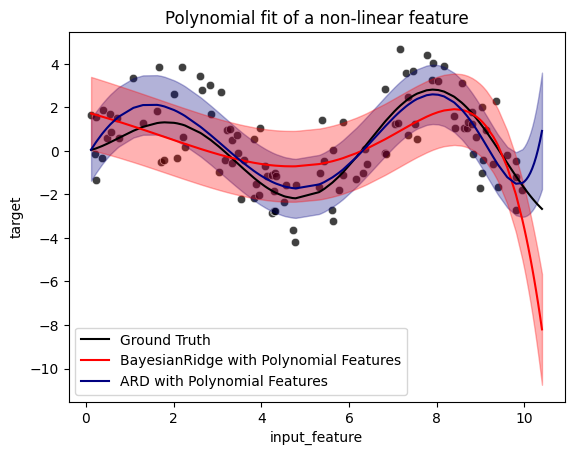

In [48]:
ax = sns.scatterplot(data = full_data, x = "input_feature", y = "target", color = "black", alpha = 0.75)
ax.plot(X_plot, y_plot, color = "black", label = "Ground Truth")
ax.plot(X_plot, y_brr, color = "red", label = "BayesianRidge with Polynomial Features")
ax.plot(X_plot, y_ard, color = 'navy', label = "ARD with Polynomial Features")

ax.fill_between(
                    X_plot.ravel(), 
                    y_ard - y_ard_st_dev,
                    y_ard + y_ard_st_dev,
                    color = "navy", 
                    alpha = 0.3
                )

ax.fill_between(
                    X_plot.ravel(), 
                    y_brr - y_brr_st_dev,
                    y_brr + y_brr_st_dev,
                    color = "red",
                    alpha = 0.3,
                )

ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")

The error bars represent one standard deviation of the predicted gaussian distribtuion of the query points. Notice that the ARD regression captures the ground truth the best when using the default parameters in both models, but further reducing the lambda_init hyperparameter of the Bayesian Ridge can reduce its bias. Finally, due to the intrinsic limitations of a polynomial regression, both models fail when extrapolating. 

<b><i>The End.</i></b>